In [76]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder

In [77]:
# Extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# Saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(clients_merged.isnull().sum()) # missing values in Age and Job
print(balances.isna().sum()) # no missing values

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object
client_id          0
age              232
job              438
marital            0
education          0
gender             0
has_deposits       0
loan               0
has_insurance      0
has_mortgage       0
dtype: int64
date         0
balance      0
client_id    0
currency     0
dtype: int64


In [78]:
# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

In [79]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [80]:
# extracting encoding labels
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [81]:
clients_merged

,client_id,age,job,marital,education,gender,has_deposits,loan,has_insurance,has_mortgage,has_deposits_enc,loan_enc,has_insurance_enc,has_mortgage_enc,marital_enc,education_enc,gender_enc,job_enc
0,249789938,38.0,services,married,secondary,M,yes,no,n,no,1,0,0,0,1,1,1,7
1,1222646323,46.0,services,divorced,unknown,M,no,no,n,no,0,0,0,0,0,3,1,7
2,451375919,33.0,admin.,single,secondary,F,no,no,n,yes,0,0,0,1,2,1,0,0
3,338972671,44.0,self-employed,married,secondary,F,no,no,y,yes,0,0,1,1,1,1,0,6
4,1472834688,36.0,blue-collar,married,primary,M,yes,no,n,yes,1,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,543198889,40.0,blue-collar,single,unknown,M,no,no,n,yes,0,0,0,1,2,3,1,1
11158,458558558,41.0,housemaid,divorced,primary,F,no,no,n,yes,0,0,0,1,0,0,0,3
11159,1426334329,59.0,technician,married,primary,F,no,no,y,yes,0,0,1,1,1,0,0,9
11160,831035343,42.0,management,married,tertiary,M,no,no,n,no,0,0,0,0,1,2,1,4


In [82]:
# feature engineering: balances
# last balance, mean balance, min balance, max balance
balances['date'] = pd.to_datetime(balances['date'])

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance'].min().reset_index()
min_bal_by_client.rename(columns={'balance': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance'].max().reset_index()
max_bal_by_client.rename(columns={'balance': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

In [83]:
clients_merged

,client_id,age,job,marital,education,gender,has_deposits,loan,has_insurance,has_mortgage,...,has_insurance_enc,has_mortgage_enc,marital_enc,education_enc,gender_enc,job_enc,last_balance,mean_balance,min_balance,max_balance
0,249789938,38.0,services,married,secondary,M,yes,no,n,no,...,0,0,1,1,1,7,2680.467773,2669.532734,2515.500059,2775.615374
1,1222646323,46.0,services,divorced,unknown,M,no,no,n,no,...,0,0,0,3,1,7,1005.302876,960.562073,886.126906,1054.517907
2,451375919,33.0,admin.,single,secondary,F,no,no,n,yes,...,0,1,2,1,0,0,1100.917203,1221.016419,1100.917203,1303.494818
3,338972671,44.0,self-employed,married,secondary,F,no,no,y,yes,...,1,1,1,1,0,6,357.676547,297.993265,202.053088,446.676191
4,1472834688,36.0,blue-collar,married,primary,M,yes,no,n,yes,...,0,1,1,0,1,1,1906.382731,1919.318145,1853.387429,2011.939205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,543198889,40.0,blue-collar,single,unknown,M,no,no,n,yes,...,0,1,2,3,1,1,5.538113,18.441905,-98.265981,125.568092
11158,458558558,41.0,housemaid,divorced,primary,F,no,no,n,yes,...,0,1,0,0,0,3,70.463701,25.552707,-117.991255,116.816943
11159,1426334329,59.0,technician,married,primary,F,no,no,y,yes,...,1,1,1,0,0,9,3232.008038,3157.720202,3024.384824,3263.371390
11160,831035343,42.0,management,married,tertiary,M,no,no,n,no,...,0,0,1,2,1,4,24693.396851,24771.387533,24678.831382,24872.197971


In [84]:
# joining evaluation table with cleaned client table
first_round_clients = pd.merge(inv_campaign_eval, clients_merged, on = 'client_id')
first_round_clients

,client_id,poutcome,age,job,marital,education,gender,has_deposits,loan,has_insurance,...,has_insurance_enc,has_mortgage_enc,marital_enc,education_enc,gender_enc,job_enc,last_balance,mean_balance,min_balance,max_balance
0,249789938,success,38.0,services,married,secondary,M,yes,no,n,...,0,0,1,1,1,7,2680.467773,2669.532734,2515.500059,2775.615374
1,1504633819,failure,38.0,management,married,tertiary,M,no,yes,n,...,0,1,1,2,1,4,5476.241582,5440.862334,5344.385346,5529.866975
2,1952195738,success,34.0,services,married,secondary,M,yes,yes,n,...,0,0,1,1,1,7,2935.906506,2922.958852,2852.824056,3016.314818
3,989726384,success,62.0,retired,married,secondary,F,yes,no,n,...,0,0,1,1,0,5,3042.641066,3124.614843,3011.445910,3212.174671
4,1971878545,failure,36.0,management,single,tertiary,M,yes,no,n,...,0,0,2,2,1,4,526.157661,474.083033,362.809777,571.028715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,1270855655,failure,58.0,admin.,divorced,secondary,F,yes,no,y,...,1,1,0,1,0,0,3353.741381,3349.398115,3245.043023,3445.072323
2295,471724023,success,72.0,retired,married,primary,M,yes,no,n,...,0,0,1,0,1,5,4617.207488,4645.473515,4493.914363,4736.613098
2296,620088171,failure,34.0,admin.,married,tertiary,F,yes,no,y,...,1,1,1,2,0,0,939.603482,895.455390,771.707441,979.161966
2297,1518319265,success,39.0,management,married,unknown,F,yes,no,n,...,0,0,1,3,0,4,10.524798,77.494621,-36.431915,226.953215


In [85]:
print(clients_merged.dtypes)

client_id              int64
age                  float64
job                   object
marital               object
education             object
gender                object
has_deposits          object
loan                  object
has_insurance         object
has_mortgage          object
has_deposits_enc       int64
loan_enc               int64
has_insurance_enc      int64
has_mortgage_enc       int64
marital_enc            int64
education_enc          int64
gender_enc             int64
job_enc                int64
last_balance         float64
mean_balance         float64
min_balance          float64
max_balance          float64
dtype: object


       client_id  poutcome   age  has_deposits_enc  loan_enc  \
0      249789938         1  38.0                 1         0   
1     1504633819         0  38.0                 0         1   
2     1952195738         1  34.0                 1         1   
3      989726384         1  62.0                 1         0   
4     1971878545         0  36.0                 1         0   
...          ...       ...   ...               ...       ...   
2294  1270855655         0  58.0                 1         0   
2295   471724023         1  72.0                 1         0   
2296   620088171         0  34.0                 1         0   
2297  1518319265         1  39.0                 1         0   
2298   705801685         1  36.0                 1         0   

      has_insurance_enc  has_mortgage_enc  marital_enc  education_enc  \
0                     0                 0            1              1   
1                     0                 1            1              2   
2           

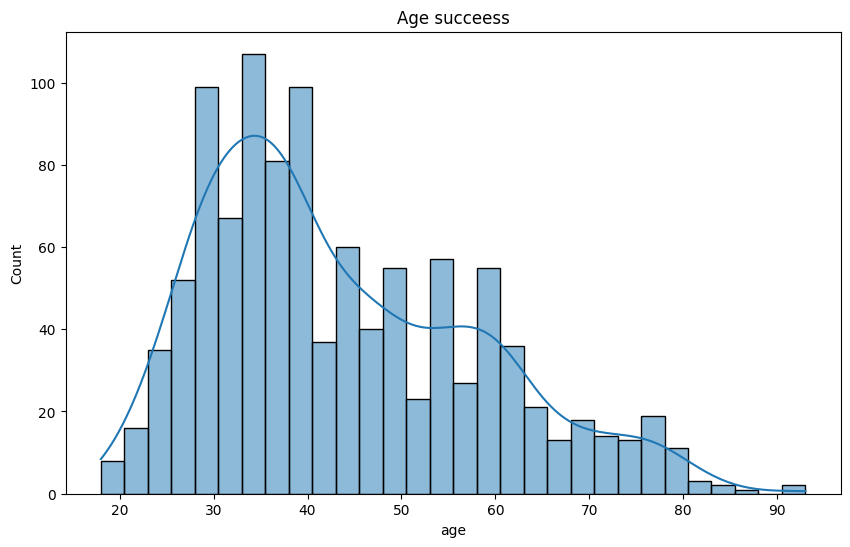

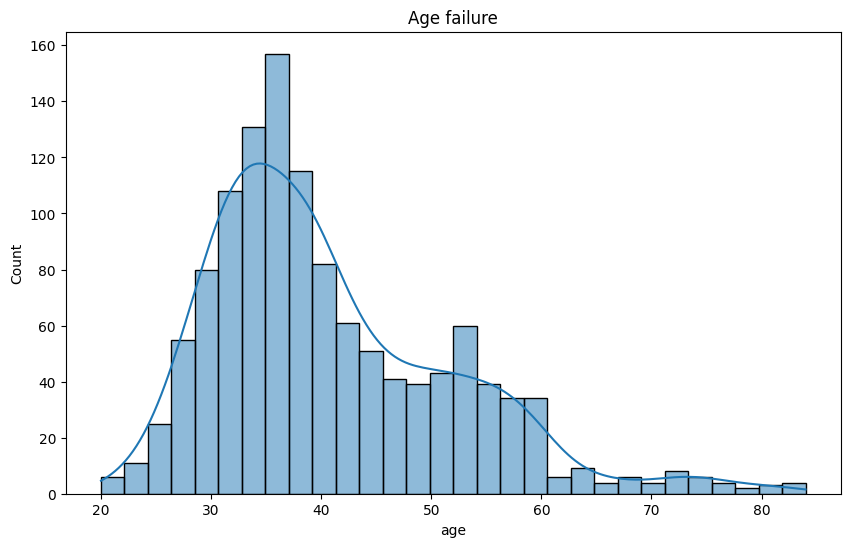

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping for replacement
replacement_mapping = {'success': 1, 'failure': 0}

# Replacing values in the 'poutcome' column
first_round_clients['poutcome'] = first_round_clients['poutcome'].replace(replacement_mapping)

first_round_clients = first_round_clients.drop(['job','marital','education','gender','has_deposits','has_insurance', 'loan','has_mortgage'], axis=1)
# Displaying the updated DataFrame
print(first_round_clients)

success_results = first_round_clients.loc[first_round_clients['poutcome'] == 1]
print(success_results)
print(success_results.count())

failure_results = first_round_clients.loc[first_round_clients['poutcome'] == 0]
print(failure_results)

# HISTOGRAM AGE
# Plotting a histogram for one of the features in the dataset
plt.figure(figsize=(10,6))
sns.histplot(data=success_results, x='age', bins=30, kde=True)
plt.title('Age succeess')
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# HISTOGRAM AGE
# Plotting a histogram for one of the features in the dataset
plt.figure(figsize=(10,6))
sns.histplot(data=failure_results, x='age', bins=30, kde=True)
plt.title('Age failure')
plt.show()


In [87]:
print(first_round_clients.columns)
print(first_round_clients.info())

Index(['client_id', 'poutcome', 'age', 'has_deposits_enc', 'loan_enc',
       'has_insurance_enc', 'has_mortgage_enc', 'marital_enc', 'education_enc',
       'gender_enc', 'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          2299 non-null   int64  
 1   poutcome           2299 non-null   int64  
 2   age                2299 non-null   float64
 3   has_deposits_enc   2299 non-null   int64  
 4   loan_enc           2299 non-null   int64  
 5   has_insurance_enc  2299 non-null   int64  
 6   has_mortgage_enc   2299 non-null   int64  
 7   marital_enc        2299 non-null   int64  
 8   education_enc      2299 non-null   int64  
 9   gender_enc         2299 non-null   int64  
 10  job_enc            2299 non-null   in

In [88]:
print(success_results.count().client_id)
print(failure_results.count().client_id)

1071
1228


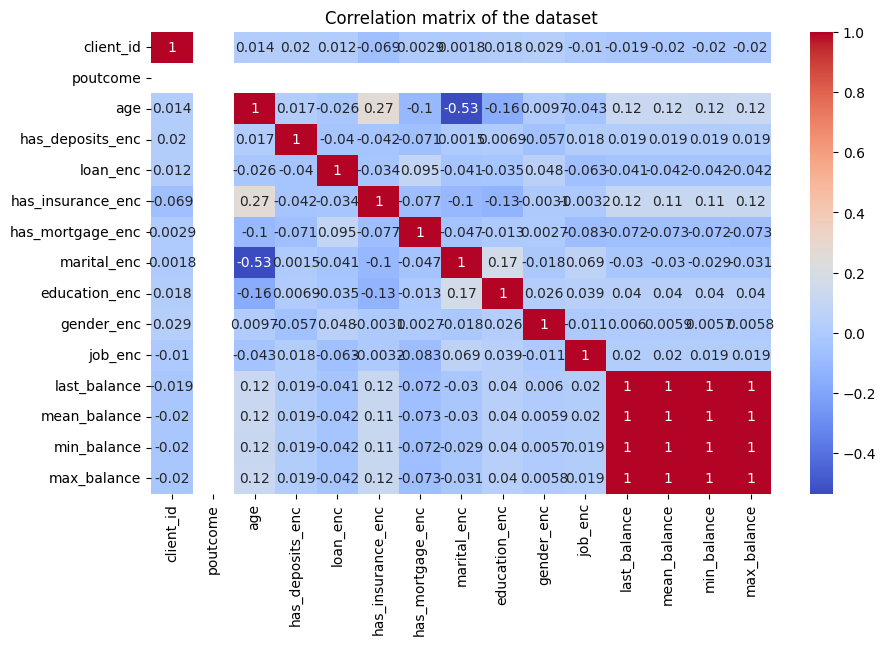

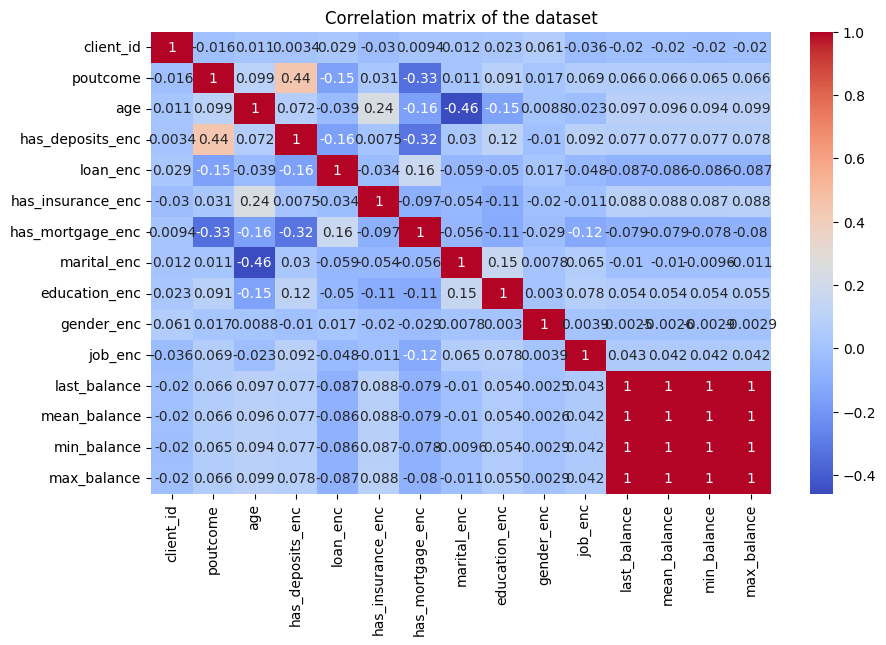

In [89]:
# CORRELATION MATRIX
# Calculating the correlation matrix
corr = success_results.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the dataset')
plt.show()

# CORRELATION MATRIX
# Calculating the correlation matrix
corr = first_round_clients.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the dataset')
plt.show()

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Random Forest
X = first_round_clients.drop('poutcome', axis=1)
y = first_round_clients['poutcome']  # Target variable

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train (fit) the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 70.65%
[[165  76]
 [ 59 160]]


[1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0
 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1
 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1
 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0
 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0
 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0
 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1]
[[172  69]
 [ 67 152]]
              precision    recall  f1-score

/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


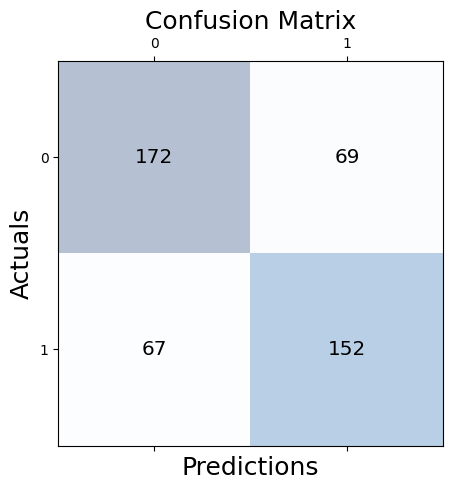

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Logistic Regression
X = first_round_clients.drop('poutcome', axis=1)
y = first_round_clients['poutcome']  # Target variable


# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Create Logistic Regression model
logreg = LogisticRegression(max_iter=2000)

# Train the model using the training sets
logreg.fit(X_train_scaled, y_train)

# Predictions on the Test dataset
y_pred = logreg.predict(scaler.transform(X_test))

print(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Accuracy
print("Accuracy: ", logreg.score(X_test, y_test))

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='x-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()